This is a notebook that walks through of the implicit neural representation example considered in "The Linear Centroids Hypothesis: How Deep Networks Represent Features", which demonstrates how centroids can be used to identify the features of a deep network (DN).

In [12]:
## Imports and Utility Functions

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import argparse
from tqdm import tqdm
import copy
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import *

In [13]:
# Here we set-up the hyperparameters of the example.
device='cuda'
defaults=dict(
    # data distribution
    shape='star', # use bowtie or reuleuax to explore other shapes
    num_inside=4096, # training points sampled from within the polygon
    num_outside=4096, # training points sampled from outside the polygon

    # optimization parameters
    batch_size=128,
    lr=1e-3,
    nsteps=1024,
    # model parameters
    activation='ReLU', # consider ReLU or GELU
    width=64,
    depth=3,
    seed=1234
)
config=argparse.Namespace(**defaults)

torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)
np.random.seed(config.seed)

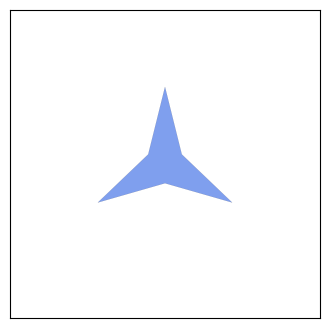

In [14]:
# We start by generating the polygon which will define our classification task. We use the star-shaped polygon to be consistent with the main-text of the paper, however, bowtie and reuleuax shaped polygons are also available.

polygon=generate_polygon(config.shape)

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
x,y=polygon.exterior.xy
ax.fill(x,y,alpha=0.5,edgecolor='black',facecolor=plt.cm.winter(0.25),linewidth=0.1)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
clean_axis(ax)
plt.show()

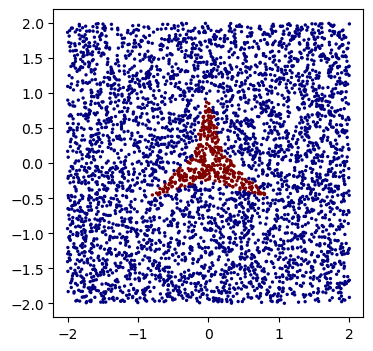

In [15]:
# Next we use this polygon to generate a dataset to train a DN to classify the interior and exterior of this polygon.

dataset,points,labels=generate_datatset(polygon,num_inside=config.num_inside,num_outside=config.num_outside)

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
ax.scatter(points[:,0],points[:,1],c=labels,cmap='jet',s=2)
plt.show()

# With this dataset we can create the loader.

loader=torch.utils.data.DataLoader(dataset,batch_size=config.batch_size)

In [16]:
# We now construct the model that is going to be used to train the DN. Here we just use a simple fully connected DN.

model=construct_model(config)
model.to(device)

optimizer=torch.optim.AdamW(model.parameters(),lr=config.lr)

In [17]:
# With this we can now train the DN.
model.train()
pbar=tqdm(range(config.nsteps))
for step in pbar:
    for x,y in loader:
        x,y=x.to(device),y.to(device)
        optimizer.zero_grad()
        output=model(x).squeeze(1)
        loss=nn.BCEWithLogitsLoss()(output,y.float())
        loss.backward()
        optimizer.step()
    pbar.set_description(f'{loss.item():.4f}')

print(compute_accuracy(model,loader,device))

0.0001: 100%|██████████| 1024/1024 [01:36<00:00, 10.67it/s]


1.0


In [18]:
# We can now start investigating this trained artifact. For this we create a hard and a soft model. The hard model will be the DN with ReLU nonlinearities whereas the soft model will have GELU nonlinearities.

if config.activation=='ReLU':
    soft_model=update_model(model)
    hard_model=copy.deepcopy(model)
elif config.activation=='GELU':
    hard_model=update_model(model)
    soft_model=copy.deepcopy(model)

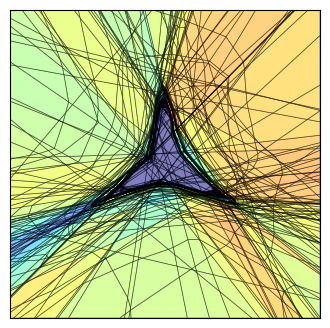

layer 1


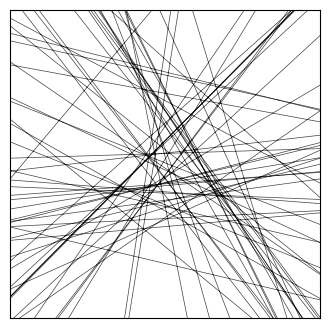

layer 2


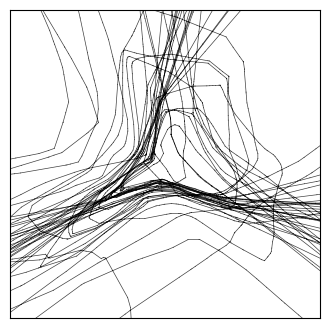

layer 3


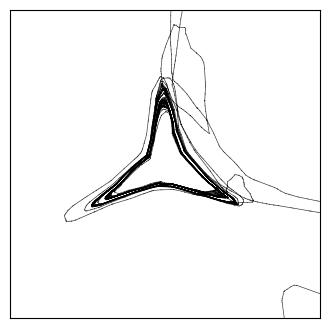

In [19]:
# For the hard model we can visualise its functional geometry using SplineCam

cycles,Abw,added_cycles=compute_partition(hard_model)

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
plot_partition(ax,cycles,Abw)
plt.show()

minval,_ = torch.vstack(cycles).min(0)
maxval,_ = torch.vstack(cycles).max(0)

for layer,edges in added_cycles.items():
    print(f'layer {layer}')
    fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
    plot_edges(ax,cycles,edges)
    plt.show()

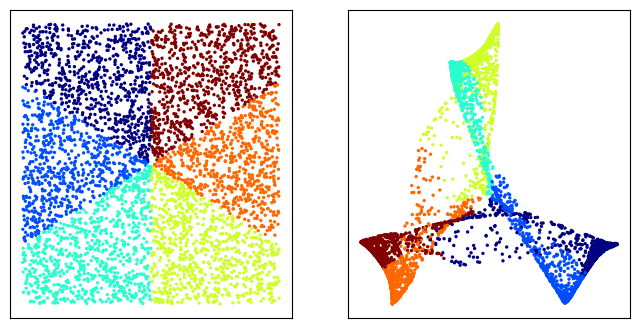

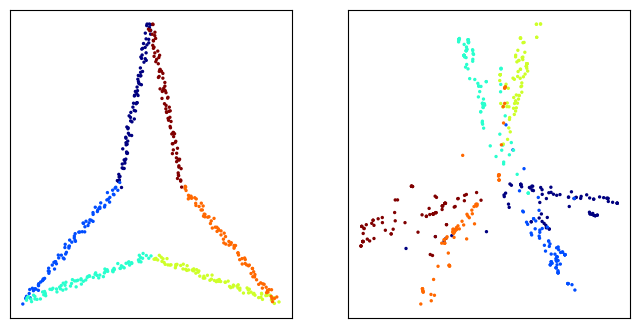

In [20]:
# We start by visualise the centroids obtained from the training sample, and to help identify the centroids to their corresponding latent activations we colour them according to what sector of the input space they come from.

npoints=points.detach().cpu().numpy()
sector_labels=label_points_by_sector(npoints)
centroids=Centroids(soft_model)(points).get_centroids().detach().cpu().numpy()

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,4))
ax[0].scatter(npoints[:,0],npoints[:,1],c=sector_labels,cmap='jet',s=2)
clean_axis(ax[0])
ax[1].scatter(centroids[:,0],centroids[:,1],c=sector_labels,cmap='jet',s=2)
clean_axis(ax[1])
plt.show()

# We additionaly just focus on the centroids obtained from a sample of points from the edges of the polygon.

edge_points,edge_labels=sample_edges(polygon,512)
edge_points+=(2*np.random.random(edge_points.shape)-1)*0.02
tedge_points=torch.tensor(edge_points)
edge_centroids=Centroids(hard_model)(tedge_points).get_centroids().detach().cpu().numpy()
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,4))
ax[0].scatter(edge_points[:,0],edge_points[:,1],c=edge_labels,cmap='jet',s=2)
clean_axis(ax[0])
ax[1].scatter(edge_centroids[:,0],edge_centroids[:,1],c=edge_labels,cmap='jet',s=2)
clean_axis(ax[1])
plt.show()

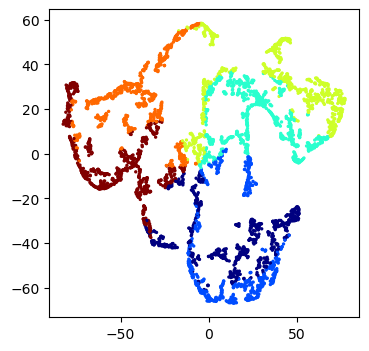

In [21]:
# As a first experiment we just embed the centroids of the penultimate using t-SNE.

activations=soft_model[:-5](points.to(device))
nactivations=activations.detach().cpu().numpy()
ncentroids=Centroids(soft_model[-5:])(activations).get_centroids().detach().cpu().numpy()

tsne=TSNE(n_components=2)
ncentroids=tsne.fit_transform(ncentroids)

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
ax.scatter(ncentroids[:,0],ncentroids[:,1],c=sector_labels,cmap='jet',s=2)
plt.show()

layer 2 - neuron 11


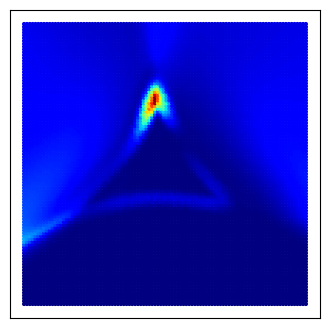

layer 2 - neuron 38


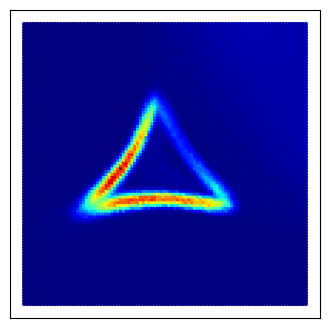

layer 2 - neuron 61


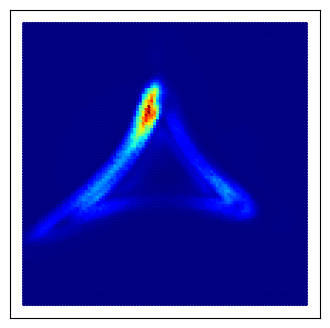

layer 4 - neuron 23


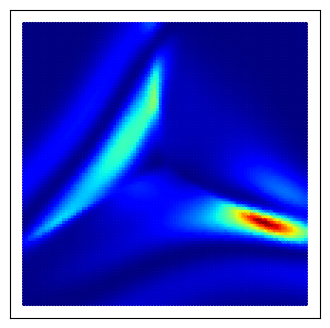

layer 4 - neuron 63


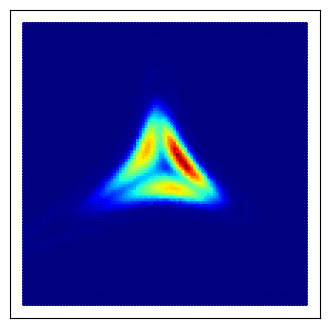

layer 4 - neuron 25


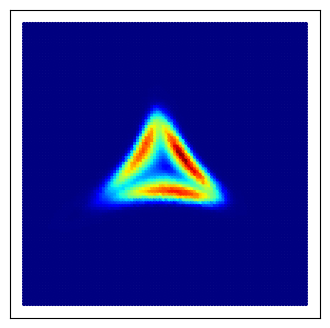

In [22]:
# We utilise the neuron attribution method derived in the main-text. More specifically, on a grid sample from the input space we evaluate it for a sample of neurons from the penultimate and last layer of the DN.

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
xx, yy = np.meshgrid(x, y)
grid_sample = np.stack([xx.ravel(), yy.ravel()], axis=-1)
grid_sample_labels=label_points_by_sector(grid_sample,start_angle_deg=90)

for i,layer in enumerate([2,4]):
    for neuron in np.random.choice(range(config.width),size=3,replace=False):
        print(f'layer {layer} - neuron {neuron}')
        ns=neuron_attribution(soft_model,neuron,layer,grid_sample,device)
        fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
        ax.scatter(grid_sample[:,0],grid_sample[:,1],s=4,c=ns,cmap='jet')
        clean_axis(ax)
        plt.show()